# Ensemble Learning

## Initial Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [3]:
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df = pd.get_dummies(df, columns = ["home_ownership","verification_status","issue_d","pymnt_plan","initial_list_status","application_type","hardship_flag", "debt_settlement_flag","next_pymnt_d"])
df.head()

,loan_amnt,int_rate,installment,annual_inc,loan_status,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019
0,10500.0,0.1719,375.35,66000.0,low_risk,27.24,0.0,0.0,8.0,0.0,...,1,1,0,1,1,0,1,1,0,1
1,25000.0,0.2000,929.09,105000.0,low_risk,20.23,0.0,0.0,17.0,1.0,...,1,1,0,1,1,0,1,1,0,1
2,20000.0,0.2000,529.88,56000.0,low_risk,24.26,0.0,0.0,8.0,0.0,...,1,1,0,1,1,0,1,1,0,1
3,10000.0,0.1640,353.55,92000.0,low_risk,31.44,0.0,1.0,10.0,1.0,...,1,1,0,1,1,0,1,1,0,1
4,22000.0,0.1474,520.39,52000.0,low_risk,18.76,0.0,1.0,14.0,0.0,...,1,1,0,1,1,0,1,1,0,1


## Split the Data into Training and Testing

In [5]:
# Create our features
X = df.drop(columns = 'loan_status')

# Create our target
y = df.loan_status

In [6]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,issue_d_Mar-2019,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,debt_settlement_flag_N,next_pymnt_d_Apr-2019,next_pymnt_d_May-2019
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.0,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,68817.0,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.177238,1.0,0.123879,0.876121,0.860340,0.139660,1.0,1.0,0.383161,0.616839
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.381873,0.0,0.329446,0.329446,0.346637,0.346637,0.0,0.0,0.486161,0.486161
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,1.0,1.0,0.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,1.0,1.0,0.000000,1.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,1.0,0.000000,1.000000,1.000000,0.000000,1.0,1.0,1.000000,1.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,1.000000


In [7]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [8]:
# Create X_train, X_test, y_train, y_test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [10]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [11]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [12]:
# Resample the training data with the BalancedRandomForestClassifier
rf_model = BalancedRandomForestClassifier(n_estimators=100, random_state=78)
rf_model = rf_model.fit(X_train_scaled, y_train)
predictions = rf_model.predict(X_test_scaled)

In [13]:
# Calculated the balanced accuracy score
acc_score = balanced_accuracy_score(y_test, predictions)
acc_score

0.7776095741123479

In [14]:
# Display the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
cm_df

,Predicted 0,Predicted 1
Actual 0,57,30
Actual 1,1711,15407


In [15]:
# Print the imbalanced classification report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

   high_risk       0.03      0.66      0.06        87
    low_risk       1.00      0.90      0.95     17118

    accuracy                           0.90     17205
   macro avg       0.52      0.78      0.50     17205
weighted avg       0.99      0.90      0.94     17205



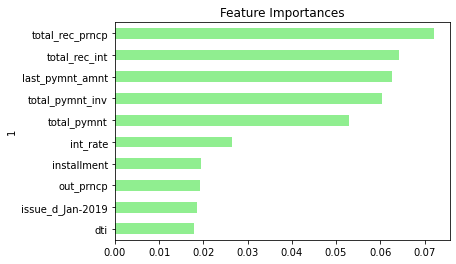

In [16]:
# List the features sorted in descending order by feature importance
sorted_list = sorted(zip(rf_model.feature_importances_, X.columns), reverse = True)
sorted_list = sorted_list[0:10]
importances_df = pd.DataFrame(sorted_list)
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Feature Importances', legend=False);

### Easy Ensemble Classifier
#### !!! PLEASE NOTE THAT THE EasyEnsembleClassifier CODE HAS A BUG !!! 
#### RE: https://github.com/scikit-learn-contrib/imbalanced-learn/issues/872

In [21]:
# Train the Classifier
ee_model = EasyEnsembleClassifier()
ee_model.fit(X_train_scaled, y_train)

AttributeError: 'EasyEnsembleClassifier' object has no attribute 'n_features_in_'

In [22]:
# Calculated the balanced accuracy score
ee_pred = ee_model.predict(X_test_scaled)
accuracy_score(y_test, ee_pred)

AttributeError: 'EasyEnsembleClassifier' object has no attribute 'estimators_'

In [23]:
# Display the confusion matrix
confusion_matrix(y_test, ee_pred)

NameError: name 'ee_pred' is not defined

In [24]:
# Print the imbalanced classification report
print(classification_report(y_test, ee_pred))

NameError: name 'ee_pred' is not defined

### Final Questions

1. Which model had the best balanced accuracy score?

    YOUR ANSWER HERE.

2. Which model had the best recall score?

    YOUR ANSWER HERE.

3. Which model had the best geometric mean score?

    YOUR ANSWER HERE.

4. What are the top three features?

    YOUR ANSWER HERE.